In [1]:
import numpy as np
import pandas as pd
import itertools
import sys
from graphviz import Digraph


## -Loading datasets (df1 = Tenis Dataset , df2 = mushrooms dataset, df3 = iris dataset continous)

In [2]:

df = pd.read_csv('../ressources/data.csv')# discret  Dataset
df2 = pd.read_csv('../ressources/mushrooms.csv')# discret  Dataset
df3 = pd.read_csv('../ressources/iris.csv')# continous Dataset

## - Tree Decision Class

In [3]:
class Tree: #tree class
    def __init__(self):
        self.sons = {}
        self.Attribute = None #Attribues are a dictionary dic[ith att] = ith son
    def add_son(self, son, att):
        self.sons[att] = son
    def set_att(self, att):
        self.Attribute = att
    def check(self, data, continious = False):
        tmpAt  = self
        if not(continious):
            while (tmpAt.sons != {}):
                tmpAt = tmpAt.sons[data[tmpAt.Attribute]]
        return tmpAt.Attribute
    def get_val_att(self, val):
        for key, value in self.sons.items():
            if val in key:
                return key
        return None
    def genView(self, dot, continous=False): #generate the view
        label = self.Attribute
        dot.node(str(self), label)
        for key, son in self.sons.items():
            k = None
            if (continous):
                if (type(key) ==  type(pd.Interval(left=0, right=5)) ):
                    k =  ']' + str(key.left) + ";" + str(key.right)  +']'
                else :
                    k = str(key)
            else:
                k = key
            k = k.encode().decode('utf-8')
            dot.edge(str(self), str(son), label= k)
            son.genView(dot, continous)
           

## - Functions of decisions

### Entropy : 
The information entropy here serve to measure the uncertainty, the less uncertain we are the better is, the formula of entropy is given by : 

$$ H(T) = \sum_{i=1}^{n} pi \log(pi) $$
### Standard Information Gain :
Now suppose we partition our data by an attribute X, the information needed to classify an element of T is : 

$$ H(T,X) = \sum_{i=1}^{n} \frac{|T_i|}{|T|} H(T_i) $$
$$ H(T_i) $$ is the entropy where we partition our dataset $$T_i$$ by the target attribues value to get $$pi = \frac{|T_{ij}|}{|Ti|}$$ and j is the index of the jth attribute value.
Now we want to know, how much information we gain by choosing the attribute X to classify, is just the difference between H(T) quantity of information before partitionning and the quantity of information H(T,X) after partitionning given by the formula : 
$$G(X, T) = H(T) - H(X, T) $$
### Gain ratio :
the gain ratio is a criteria that penalize splitting the data on too much branches, suppose that we are in a hospital and we want to classify patient's deseases by patient's attributes to predict if a patient have that desease or not, if we use standard gain information our decision tree will take the identifient of patient to classify (ID) and our decision tree will be useless so we introduce Gain Ratio to avoid this case : 
$$ GainRatio(X,T) = \frac{Gain(X,T)}{SplitInfo(X,T)}$$

Where split info is the entropy of splitting a dataset by the attribute X, it H(T) where the target is the attribute X : 

### Gini index:
Gini index is a measure like the entropy (less efficient) given by the formula : 
$$ Gini(T) = \sum_{i=1}^{n} pi (1 - pi) $$ 


### Entropy functions

In [4]:
def get_entropy(data,target): # compute entropy for the given data where target give the separation 
    n = len(data)
    acc = 0
    for c  in data[target].value_counts(): #c count how much yes and no for Tenis play for example
        acc -= c/n * np.log2(c/n) #c/n reprensen porobability
    return acc # here represent entropy
def get_entropys(data, elt, target): # we want to get the H(T,X) where X is the attribute elt and T
    ents = 0
    l = [(att, x) for att,x in data.groupby(elt)] 
    n = 0
    for d in l:
        n += len(d)
        ents += len(d) * get_entropy(d[1], target)
    return ents/n, l
def get_std_gain(data, elt, target):
    ent_l = get_entropys(data, elt, target)
    return (get_entropy(data, target) - ent_l[0]), ent_l[1]
def get_gain_ratio(data, elt, target):
    d = get_entropy(data, elt)
    std = get_std_gain(data, elt, target)
    return (np.inf, std[1]) if (d == 0) else (std[0] / d, std[1])
    

### Gini index

In [5]:
def get_Gini(data,target):
    n = len(data)
    acc = 0
    for c  in data[target].value_counts():
        acc -= c/n 
    return 1 - acc
def get_Ginis(data, elt, target):
    ents = 0
    l = [(att, x) for att,x in data.groupby(elt)]
    n = 0
    for d in l:
        n += len(d)
        ents += len(d) * get_Gini(d[1], target)
    return ents/n, l
def get_std_gainG(data, elt, target):
    ent_l = get_Ginis(data, elt, target)
    return (get_Gini(data, target) -  ent_l[0]), ent_l[1]
def get_gain_ratioG(data, elt, target):
    d = get_Gini(data, elt)
    std = get_std_gainG(data, elt, target)
    return (np.inf, std[1]) if (d == 0) else std[0] / d, std[1]
    

## - ID3 Algorithm

In [6]:
def ID3(data, target, func_ent, continous = False, strat = 0):
    root = Tree()
    lis_ent = []
    if (len(set(data[target])) == 1 ):
        root.set_att(data[target].values[0])     
    else:
        for elt in data:
            if(elt == target):
                lis_ent.append([-np.inf,[]])
                continue
            ent = []
            if not(continous):
                ent = func_ent(data, elt, target)
            else :
                ent = func_ent(data, elt, target, continous, strat)
            lis_ent.append(ent)
        indop = np.argmax([lis_ent[i][0] for i in  range(len(lis_ent)) ])        
        optimal = data.columns[indop]
        if(optimal != target):
            root.set_att(optimal)
        else:
            root.set_att("Not found")
        for d in [(att, x) for att,x in lis_ent[indop][1]]:
                root.add_son(ID3(d[1].loc[:, d[1].columns != optimal], target, func_ent, continous, strat), d[0])
    return root

 ## Tenis Dataset standard information Gain 

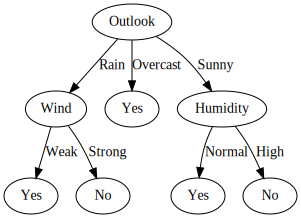

In [7]:
target = 'PlayTennis'
tree = ID3(df, target, get_std_gain)
dot = Digraph(comment="Decision tree")
tree.genView(dot)
dot

In [8]:
#check that all classifications are correct
np.all(np.array([tree.check(df.loc[i]) == df.loc[i][target] for i in range(len(df))]))

True

 ## Tenis Dataset  Gain ratio

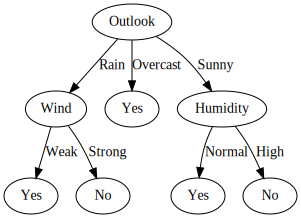

In [9]:
tree = ID3(df, target, get_gain_ratio)
dot = Digraph(comment="Decision tree")
tree.genView(dot)
dot

In [10]:
#check that all classifications are correct
np.all(np.array([tree.check(df.loc[i]) == df.loc[i][target] for i in range(len(df))]))

True

## Mushrooms Dataset standard information Gain

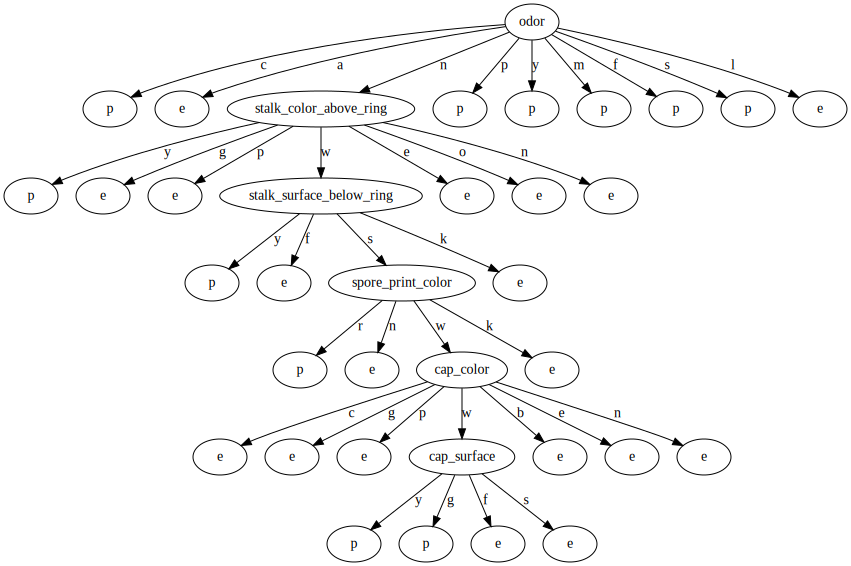

In [11]:
target2 = 'type'
tree2 = ID3(df2, target2, get_std_gain)
dot = Digraph(comment="Decision tree")
tree2.genView(dot)
dot

In [12]:
#check that all classifications are correct
np.all(np.array([tree2.check(df2.loc[i]) == df2.loc[i][target2] for i in range(len(df2))]))

True

## Mushrooms Dataset Gain ratio

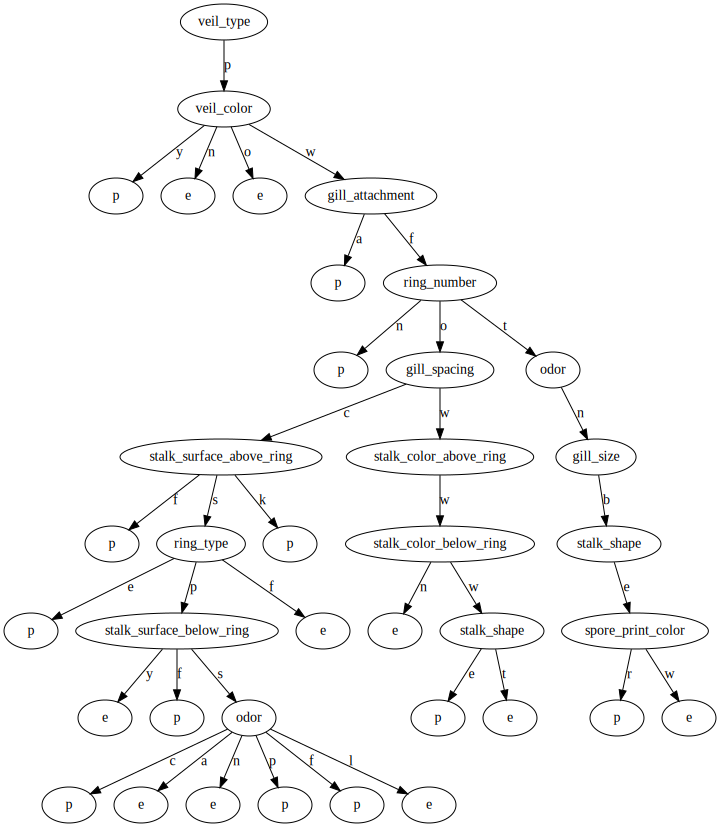

In [13]:
target2 = 'type'
tree2 = ID3(df2, target2, get_gain_ratio)
dot = Digraph(comment="Decision tree")
tree2.genView(dot)
dot

In [14]:
#check that all classifications are correct
np.all(np.array([tree2.check(df2.loc[i]) == df2.loc[i][target2] for i in range(len(df2))]))

True

## Use of Gini index instead of Entropy

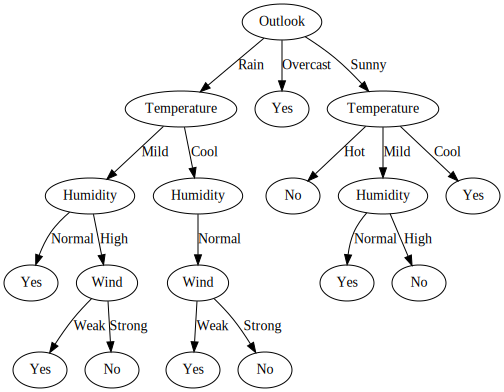

In [15]:
target = 'PlayTennis'
tree = ID3(df, target, get_std_gainG)
dot = Digraph(comment="Decision tree")
tree.genView(dot)
dot

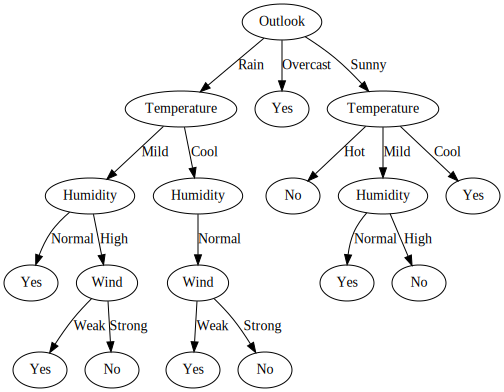

In [16]:
tree = ID3(df, target, get_gain_ratioG)
dot = Digraph(comment="Decision tree")
tree.genView(dot)
dot

In [17]:
#check that all classifications are correct
np.all(np.array([tree.check(df.loc[i]) == df.loc[i][target] for i in range(len(df))]))

True

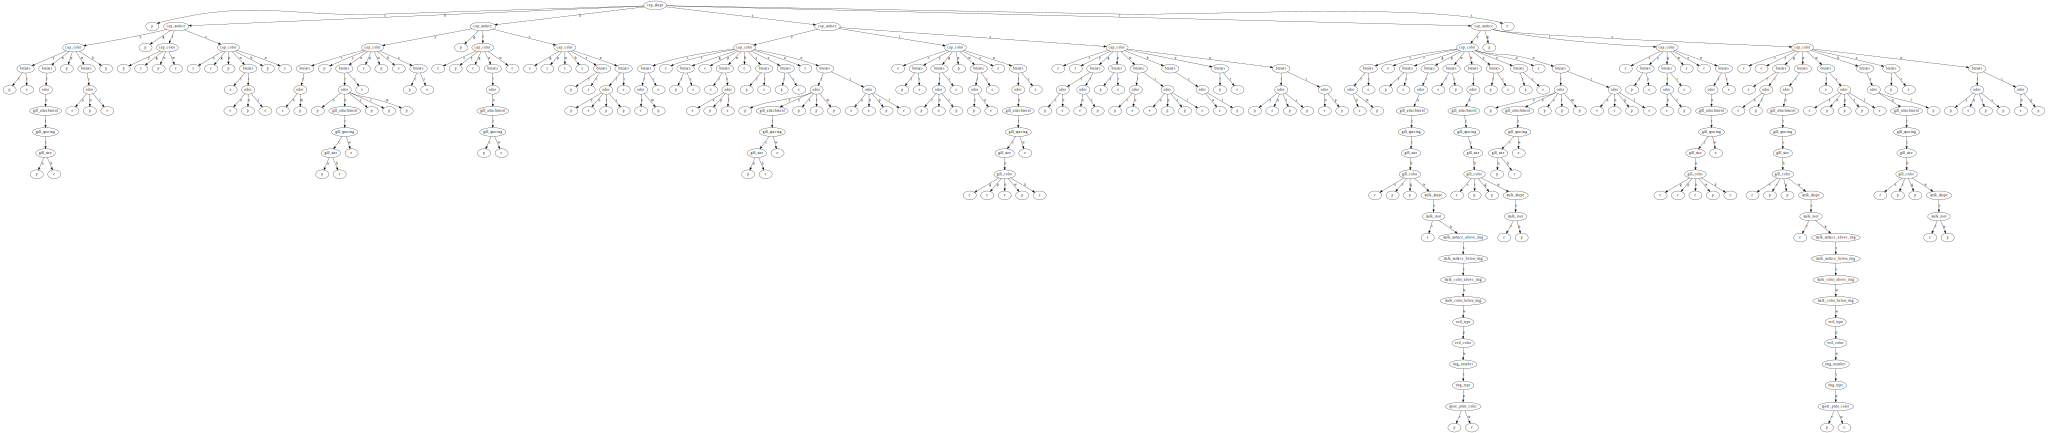

In [18]:
target2 = 'type'
tree2 = ID3(df2, target2, get_std_gainG)
dot = Digraph(comment="Decision tree")
tree2.genView(dot)
dot

In [19]:
#check that all classifications are correct
np.all(np.array([tree2.check(df2.loc[i]) == df2.loc[i][target2] for i in range(len(df2))]))

True

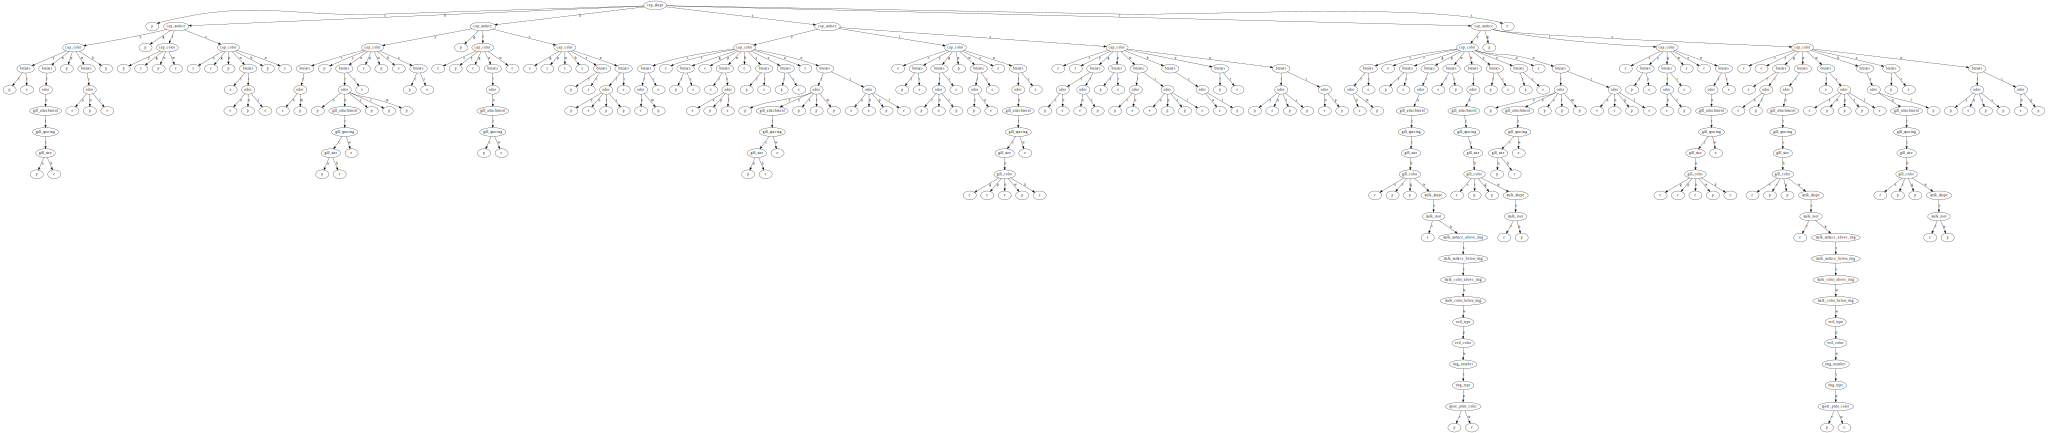

In [20]:
target2 = 'type'
tree2 = ID3(df2, target2, get_gain_ratioG)
dot = Digraph(comment="Decision tree")
tree2.genView(dot)
dot

In [21]:
#check that all classifications are correct
np.all(np.array([tree2.check(df2.loc[i]) == df2.loc[i][target2] for i in range(len(df2))]))

True

### Remark
The use of Gini Index give much bigger Trees

## Approch for continuous variables

- Stupid split: split in 2 intervals  in the middle between max and min value, then each interval is an attribute (strat = 0)
- Random split : split in 2 random intervals n times and chose the best split (strat = 1)
- Brut force split : split in all the possibility of 2 intervalls, choose, the best split (strat = 2)


In [22]:
# we modify a little our functions to handle continous variables and criteria of splitting with the var strat
# we just added continous variable  and strat variable to handle spllitings in continous cases
def get_entropy(data,target):
    n = len(data)
    acc = 0
    for c  in data[target].value_counts():
        acc -= c/n * np.log2(c/n)
    return acc
def get_entropys(data, elt, target, continous = False, strat = 0):
    ents = 0
    eps = 1e-7
    l = []
    if not(continous):
        l =  [(att, x) for att,x in data.groupby(elt)]
    elif(strat == 0):
        ranges = np.linspace(data[elt].min(), data[elt].max(), num = 3)
        ranges[0] = data[elt].min() - eps
        ranges[-1] = data[elt].max()
        l = [(att, x) for att,x in data.groupby(pd.cut(data[elt], ranges))]
    elif(strat == 1):
    
        ranges = (np.random.rand(3) * (data[elt].max() - data[elt].min()) + data[elt].min())
        ranges[0] = data[elt].min() - eps
        ranges[-1] = data[elt].max()
        idx = np.argsort(ranges)
        ranges = np.sort(ranges)
        l = [(att, x) for att,x in data.groupby(pd.cut(data[elt], ranges))]
    elif(strat == 2):
        ranges = np.linspace(data[elt].min(), data[elt].max(), num = 5)
        list_ranges = list(itertools.permutations(ranges))
        cmpl = []
        for ranges in list_ranges:
            ranges = np.sort(ranges[:3])
            ranges[0] -=eps
            l = [(att, x) for att,x in data.groupby(pd.cut(data[elt], ranges))]
            cmpl.append(cmp_entropys(l))
        cmpl = np.array(cmpl)
        idx = np.argmin(cmpl[:,0])
        return cmpl[idx] 
    return cmp_entropys(l)
 
def cmp_entropys(l):
    ents = 0
    n = 0
    for d in l:
        n += len(d)
        ents += len(d) * get_entropy(d[1], target)
    return ents/n, l
def get_std_gain(data, elt, target, continous = False, strat = 0):
    if(data[elt].count() == 0):
            return (-np.inf, [])
    #print(data[elt].count())
    ent_l = get_entropys(data, elt, target, continous, strat)
    return (get_entropy(data, target) - ent_l[0]), ent_l[1]
def get_gain_ratio(data, elt, target,continous = False, strat = 0):
    d = get_entropy(data, elt)
    std = get_std_gain(data, elt, target,continous, strat)
    return (np.inf, std[1]) if (d == 0) else (std[0] / d, std[1])

## Continous iris dataset

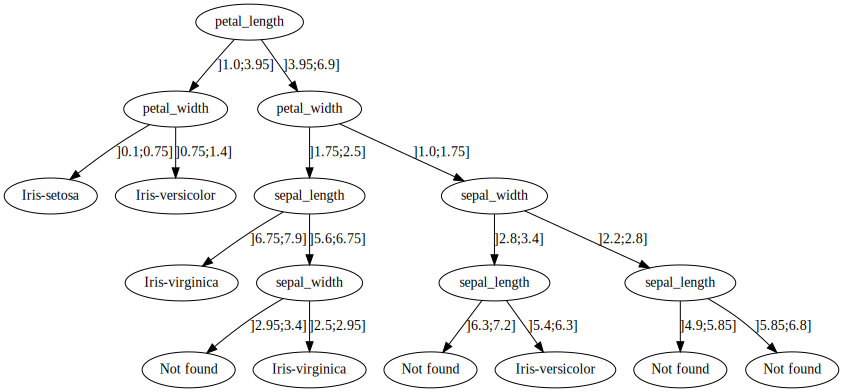

In [23]:
target = 'class'
tree = ID3(df3, target, get_std_gain, continous=True, strat=0)
dot = Digraph(comment="Decision tree")
tree.genView(dot, continous=True)
dot

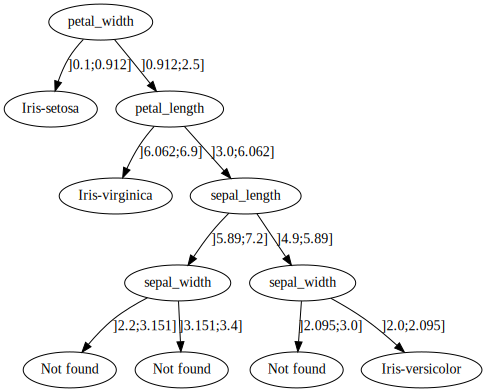

In [24]:
target = 'class'
tree = ID3(df3, target, get_std_gain, continous=True, strat=1)
dot = Digraph(comment="Decision tree")
tree.genView(dot, continous=True)
dot

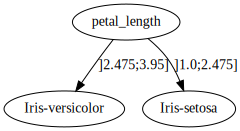

In [25]:
target = 'class'
tree = ID3(df3, target, get_std_gain, continous=True, strat=2)
dot = Digraph(comment="Decision tree")
tree.genView(dot, continous=True)
dot

In [26]:
#We obviously see that the tree do not classify well in strat 3, but i could'nt figure out why !! and i should render before it too late